In [72]:
import json
import os
import re

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns

from evaluation import evaluate

In [74]:
def load_scalability_log(graph: str):
    return parse_log(graph, evaluate.SCALABILITY_DIR)

def load_parameters_log(graph: str):
    return parse_log(graph, evaluate.PARAMS_DIR)

def load_real_world_log(setting: str):
    return parse_log(setting, evaluate.REAL_WORLD_DIR)

def parse_log(name: str, directory: str) -> list:
    pattern = re.compile(f'{name}[^"]+?\.log')
    files = os.listdir(directory)
    if any(matched := [pattern.match(f) for f in files]):
        match = [f for f in matched if f is not None][0].string
        with open(os.path.join(directory, match)) as f:
            return list(map(json.loads, f.readlines()))

def get_stats(logs: list, as_dataframe: bool = True) -> list:
    stats = []
    for log in logs:
        stat = log['Statistics'].copy()
        stat.pop('WorkerStatistics')
        stat['PerEdgeInMb'] = stat['GraphSizeInMb'] / stat['Edges']
        stats.append(stat)
    if as_dataframe:
        stats = pd.DataFrame(stats)
    return stats

def get_params(logs: list, as_dataframe: bool = True) -> list:
    params = [log['Parameters'].copy() for log in logs]
    if as_dataframe:
        params = pd.DataFrame(params)
    return params

def get_symptoms(logs: list) -> list:
    return [np.array(log['SymptomScores']) for log in logs]

def get_exposures(logs: list) -> list:
    return [np.array(log['ExposureScores']) for log in logs]

def get_membership(logs: list) -> list:
    return [np.array(log['Membership']) for log in logs]

def get_workers(logs: list, as_dataframe: bool = True) -> list:
    workers = [log['Statistics']['WorkerStatistics'].copy() for log in logs]
    if as_dataframe:
        workers = [pd.DataFrame(w) for w in workers]
    return workers

def msg_reach(init, r0, alpha, gamma):
    return np.maximum(0, np.log(gamma * alpha * r0 / init) / np.log(alpha))

def compare_reaches(symptoms, reaches, alpha, gamma, n=100_000):
    inits = np.concatenate(symptoms) * alpha
    expected = np.concatenate([
        msg_reach(init=i, alpha=alpha, gamma=gamma, r0=np.linspace(1e-5, 1, n))
        for i in inits])
    expected = np.array([expected.mean(), sp.stats.sem(expected)])
    reaches = reaches.flatten()
    actual = np.array([reaches.mean(), sp.stats.sem(reaches)])
    return expected, actual

## Parameter Experiments

In [3]:
def save_tolerance_data(df: pd.DataFrame, y: str, label: str = None):
    if label is None:
        label = y
    df2 = df[['SendTolerance', y, 'Transmission']]
    df2.index = df2['SendTolerance']
    df2.drop(columns='SendTolerance', inplace=True)
    df2.to_csv(f'figures//tolerance-{label.lower()}.csv')

In [4]:
graphs = ('power', 'lfr', 'geometric')
category = ('stats', 'params', 'workers')
analyze = ('Updates', 'RuntimeInSeconds', 'Messages')
funcs = (get_stats, get_params, get_workers)

all_logs = {}

for g in graphs:
    logs = load_parameters_log(g)
    all_logs[g] = {c: f(logs) for c, f in zip(category, funcs)}

for graph, log in all_logs.items():
    log['stats']['Graph'] = len(log['stats']) * [graph]

all_stats = pd.concat([all_logs[g]['stats'] for g in graphs])
all_params = pd.concat([all_logs[g]['params'] for g in graphs])

df = pd.concat([all_stats, all_params], axis=1)
df = df[['Graph', 'SendTolerance', 'Transmission', *analyze]]
for stat in analyze:
    df[f'Normalized{stat}'] = df[stat] / df.groupby(['Graph', 'Transmission'])[stat].transform('max')

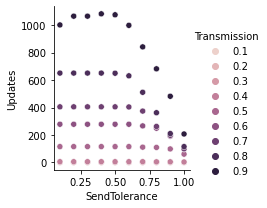

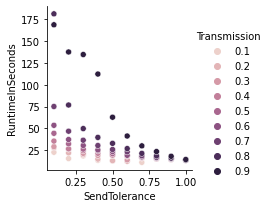

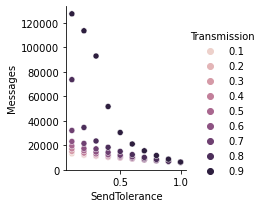

In [5]:
data = df.loc[(df['Graph'] == 'power')]
for stat in analyze:
    sns.relplot(data=data, x='SendTolerance', y=stat, hue='Transmission', legend='full', height=3);

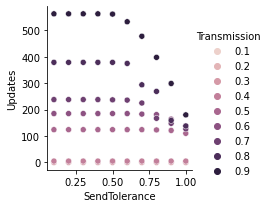

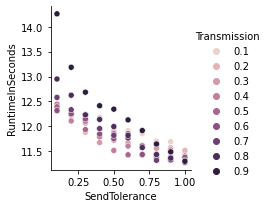

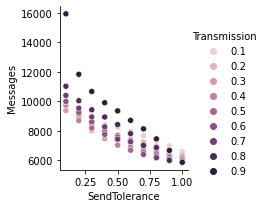

In [6]:
data = df.loc[(df['Graph'] == 'lfr')]
for stat in analyze:
    sns.relplot(data=data, x='SendTolerance', y=stat, hue='Transmission', legend='full', height=3);

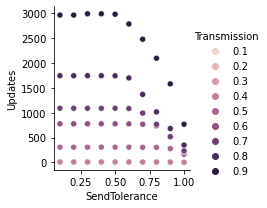

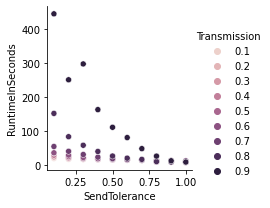

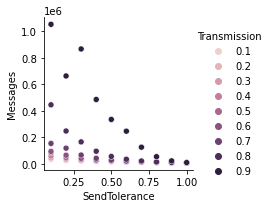

In [7]:
data = df.loc[(df['Graph'] == 'geometric')]
for stat in analyze:
    sns.relplot(data=data, x='SendTolerance', y=stat, hue='Transmission', legend='full', height=3);

In [8]:
df.groupby('SendTolerance')['NormalizedMessages'].describe()

,count,mean,std,min,25%,50%,75%,max
SendTolerance,,,,,,,,
0.1,27.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
0.2,27.0,0.782080,0.135444,0.468591,0.680921,0.799317,0.899542,0.952325
0.3,27.0,0.676351,0.183599,0.318723,0.527127,0.730694,0.838554,0.904010
0.4,27.0,0.582472,0.212903,0.212501,0.423370,0.621120,0.795218,0.854898
0.5,27.0,0.523024,0.232627,0.123967,0.302716,0.568828,0.739017,0.835733
0.6,27.0,0.475016,0.238349,0.076449,0.244202,0.521824,0.701553,0.807544
0.7,27.0,0.429728,0.240274,0.047143,0.186961,0.486953,0.648691,0.776922
0.8,27.0,0.391713,0.239581,0.031303,0.156027,0.407080,0.618137,0.742750
0.9,27.0,0.356863,0.235817,0.020506,0.126744,0.347632,0.564512,0.707666


In [9]:
df[df['Transmission'] == 0.8].groupby('SendTolerance')['NormalizedMessages'].describe()

,count,mean,std,min,25%,50%,75%,max
SendTolerance,,,,,,,,
0.1,3.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
0.2,3.0,0.644877,0.234359,0.468591,0.511901,0.555210,0.733021,0.910831
0.3,3.0,0.514765,0.295678,0.318723,0.344716,0.370709,0.612785,0.854862
0.4,3.0,0.423794,0.335381,0.212501,0.230438,0.248376,0.529440,0.810504
0.5,3.0,0.363624,0.349023,0.123967,0.163406,0.202846,0.483453,0.764060
0.6,3.0,0.317478,0.341500,0.076449,0.122081,0.167713,0.437993,0.708273
0.7,3.0,0.272978,0.316834,0.047143,0.091887,0.136631,0.385895,0.635160
0.8,3.0,0.255785,0.319772,0.031303,0.072720,0.114137,0.368027,0.621916
0.9,3.0,0.218415,0.283055,0.020506,0.056306,0.092106,0.317370,0.542634


In [10]:
df.groupby('SendTolerance')['NormalizedRuntimeInSeconds'].describe()

,count,mean,std,min,25%,50%,75%,max
SendTolerance,,,,,,,,
0.1,27.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
0.2,27.0,0.806605,0.158330,0.423229,0.710830,0.809252,0.973793,0.994633
0.3,27.0,0.742938,0.200839,0.274038,0.598562,0.734148,0.952538,0.986301
0.4,27.0,0.666324,0.238555,0.218145,0.492508,0.651546,0.942129,0.980666
0.5,27.0,0.622738,0.268090,0.170202,0.440875,0.571131,0.925554,0.962478
0.6,27.0,0.584967,0.288287,0.128676,0.376447,0.508693,0.917114,0.961925
0.7,27.0,0.564967,0.298582,0.103974,0.347423,0.547196,0.905495,0.954447
0.8,27.0,0.538456,0.315536,0.057261,0.271354,0.550151,0.890991,0.942014
0.9,27.0,0.521394,0.321445,0.026171,0.252274,0.513412,0.888498,0.941169


In [11]:
df[df['Transmission'] == 0.8].groupby('SendTolerance')['NormalizedRuntimeInSeconds'].describe()

,count,mean,std,min,25%,50%,75%,max
SendTolerance,,,,,,,,
0.1,3.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
0.2,3.0,0.648126,0.289519,0.423229,0.484795,0.546361,0.760574,0.974788
0.3,3.0,0.532530,0.360403,0.274038,0.326684,0.379330,0.661777,0.944224
0.4,3.0,0.471232,0.403973,0.218145,0.238288,0.258431,0.597775,0.937120
0.5,3.0,0.425669,0.433391,0.170202,0.175469,0.180736,0.553403,0.926069
0.6,3.0,0.396157,0.447086,0.128676,0.138089,0.147501,0.529897,0.912293
0.7,3.0,0.371474,0.451987,0.103974,0.110547,0.117120,0.505224,0.893328
0.8,3.0,0.348241,0.463198,0.060712,0.081072,0.101432,0.492006,0.882579
0.9,3.0,0.338835,0.466390,0.052435,0.069750,0.087065,0.482035,0.877004


In [12]:
df.groupby('SendTolerance')['NormalizedUpdates'].describe()

,count,mean,std,min,25%,50%,75%,max
SendTolerance,,,,,,,,
0.1,18.0,0.995381,0.017623,0.925208,1.000000,1.000000,1.000000,1.0
0.2,18.0,0.998664,0.004088,0.984303,1.000000,1.000000,1.000000,1.0
0.3,18.0,0.999128,0.003700,0.984303,1.000000,1.000000,1.000000,1.0
0.4,18.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.0
0.5,18.0,0.999011,0.001812,0.993536,0.998561,1.000000,1.000000,1.0
0.6,18.0,0.984285,0.025300,0.922438,0.978021,0.998121,1.000000,1.0
0.7,18.0,0.909078,0.086897,0.775726,0.834121,0.934417,0.989565,1.0
0.8,18.0,0.798859,0.155420,0.556068,0.701248,0.754881,0.948297,1.0
0.9,18.0,0.653924,0.215189,0.322581,0.478027,0.643399,0.839130,1.0


In [13]:
df[df['Transmission'] == 0.8].groupby('SendTolerance')['NormalizedUpdates'].describe()

,count,mean,std,min,25%,50%,75%,max
SendTolerance,,,,,,,,
0.1,3.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
0.2,3.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
0.3,3.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
0.4,3.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
0.5,3.0,0.999106,0.000798,0.998464,0.998659,0.998854,0.999427,1.000000
0.6,3.0,0.977645,0.010513,0.969278,0.971745,0.974212,0.981829,0.989446
0.7,3.0,0.781542,0.005062,0.775726,0.779840,0.783954,0.784450,0.784946
0.8,3.0,0.616022,0.082230,0.556068,0.569151,0.582235,0.645999,0.709763
0.9,3.0,0.377646,0.049799,0.322581,0.356706,0.390831,0.405178,0.419525


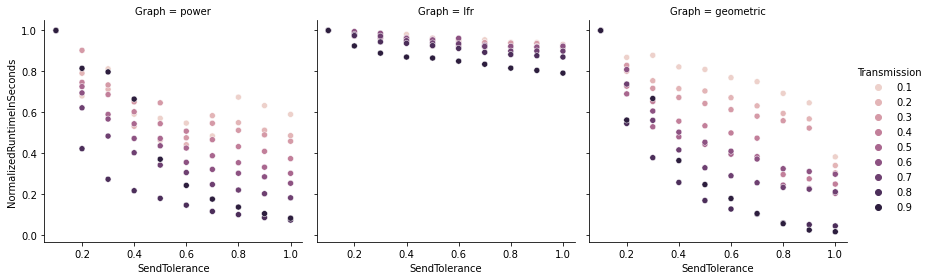

In [14]:
sns.relplot(
    data=df, 
    x='SendTolerance',
    y='NormalizedRuntimeInSeconds',
    hue='Transmission',
    col='Graph',
    height=4,
    legend='full');

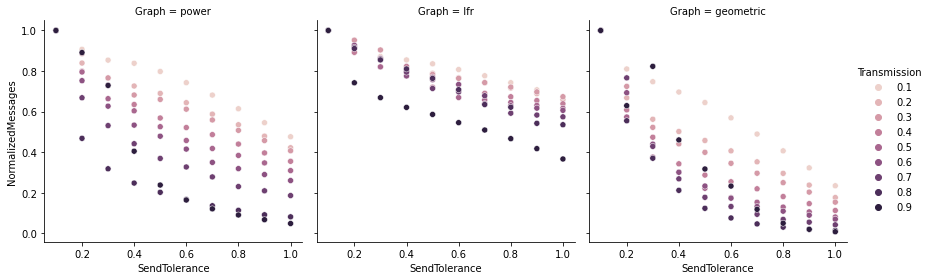

In [15]:
sns.relplot(
    data=df, 
    x='SendTolerance',
    y='NormalizedMessages',
    hue='Transmission',
    col='Graph',
    height=4,
    legend='full');

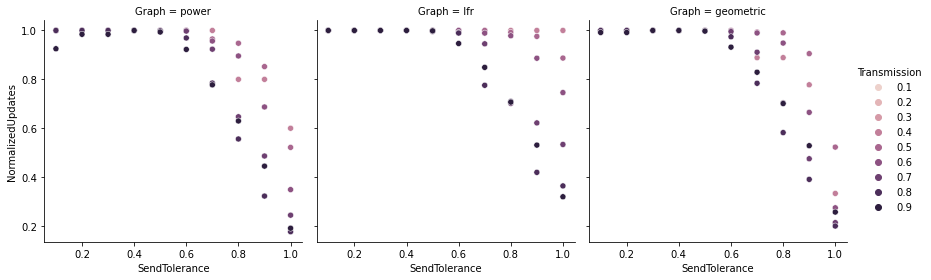

In [16]:
sns.relplot(
    data=df, 
    x='SendTolerance',
    y='NormalizedUpdates',
    hue='Transmission',
    col='Graph',
    height=4,
    legend='full');

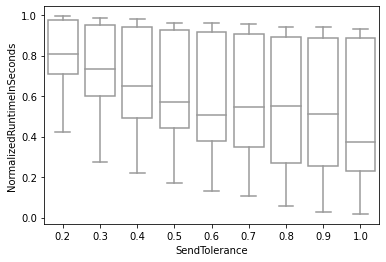

In [17]:
sns.boxplot(
    data=df[df['SendTolerance'] > 0.1],
    x='SendTolerance',
    y='NormalizedRuntimeInSeconds',
    color='white');

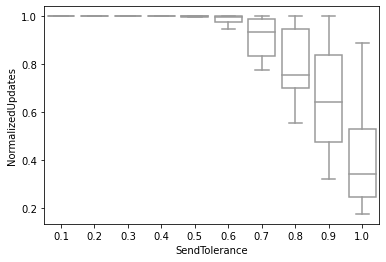

In [18]:
sns.boxplot(
    data=df,
    x='SendTolerance',
    y='NormalizedUpdates',
    color='white',
    fliersize=0);

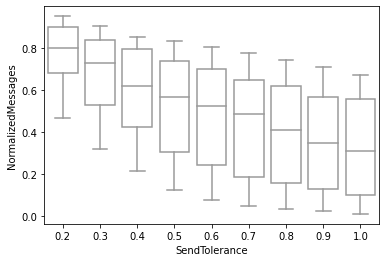

In [19]:
sns.boxplot(
    data=df[df['SendTolerance'] > 0.1],
    x='SendTolerance',
    y='NormalizedMessages',
    color='white');

In [20]:
for g, logs in all_logs.items():
    params, stats, workers = logs['params'], logs['stats'], logs['workers']

    print(f"{'=' * 80}\n{g.upper()} GRAPH\n{'=' * 80}")

    worker_nodes = np.array([w.Nodes.to_numpy() for w in workers])
    worker_nodes.sort(axis=1)
    skews = worker_nodes.T / np.sum(worker_nodes, axis=1)
    mean = np.round(skews.mean(axis=1), 4)
    std = np.round(skews.std(axis=1), 4)
    print('Worker skew:\n', f'\t{mean} +/- {std}', '\n')

    print('Early stopping:')
    for i, w in enumerate(workers):
        if 'EARLY_STOP' in w.StopCondition.values:
            tol = params.iloc[i].SendTolerance
            trans = params.iloc[i].Transmission
            print(f'\tSendTolerance={tol}, Transmission={trans}')

POWER GRAPH
Worker skew:
 	[0.1213 0.8787] +/- [0.032 0.032] 

Early stopping:
	SendTolerance=0.1, Transmission=0.9
	SendTolerance=0.2, Transmission=0.9
	SendTolerance=0.3, Transmission=0.9
LFR GRAPH
Worker skew:
 	[0.006 0.994] +/- [0. 0.] 

Early stopping:
GEOMETRIC GRAPH
Worker skew:
 	[4.000e-04 9.996e-01] +/- [0. 0.] 

Early stopping:
	SendTolerance=0.1, Transmission=0.6
	SendTolerance=0.1, Transmission=0.7
	SendTolerance=0.1, Transmission=0.8
	SendTolerance=0.1, Transmission=0.9
	SendTolerance=0.2, Transmission=0.7
	SendTolerance=0.2, Transmission=0.8
	SendTolerance=0.2, Transmission=0.9
	SendTolerance=0.3, Transmission=0.8
	SendTolerance=0.3, Transmission=0.9
	SendTolerance=0.4, Transmission=0.9
	SendTolerance=0.5, Transmission=0.9
	SendTolerance=0.6, Transmission=0.9


In [21]:
df_save = df.copy()
df_save.loc[:, 'Transmission'] *= 10
df_save.loc[:, 'Transmission'] = df_save.Transmission.astype(int)

# save_tolerance_data(df_save.loc[df_save['Transmission'] > 3], y='NormalizedUpdates', label='NormUpdates')
# save_tolerance_data(df_save, y='NormalizedRuntimeInSeconds', label='NormRuntime')
# save_tolerance_data(df_save, y='NormalizedMessages', label='NormMessages')

df.groupby(['SendTolerance'])['NormalizedUpdates'].describe().to_csv('figures//tolerance-normupdates-summary.csv')
df.groupby(['SendTolerance'])['NormalizedRuntimeInSeconds'].describe().to_csv('figures//tolerance-normruntime-summary.csv')
df.groupby(['SendTolerance'])['NormalizedMessages'].describe().to_csv('figures//tolerance-normmessages-summary.csv')

## Real-World Experiments

In [22]:
settings = ('workplace', 'highschool12', 'conference')
category = ('stats', 'params', 'workers')
funcs = (get_stats, get_params, get_workers)

all_logs = {}

for s in settings:
    logs = load_real_world_log(s)
    all_logs[s] = {c: f(logs) for c, f in zip(category, funcs)}

for setting, log in all_logs.items():
    log['stats']['Setting'] = len(log['stats']) * [setting]

all_stats = pd.concat([all_logs[s]['stats'] for s in settings])
all_params = pd.concat([all_logs[s]['params'] for s in settings])

df = pd.concat([all_stats, all_params], axis=1)

conference = df.loc[df['Setting'] == 'conference']
workplace = df.loc[df['Setting'] == 'workplace']
school = df.loc[df['Setting'] == 'highschool12']

c_reaches = np.array([r for r in conference.MessagesReachabilities.values])
w_reaches = np.array([r for r in workplace.MessagesReachabilities.values])
s_reaches = np.array([r for r in school.MessagesReachabilities.values])
reaches = (c_reaches, w_reaches, s_reaches)

In [25]:
df.groupby('Setting')[['Radius']].describe()

Radius                                   
              count mean  std  min  25%  50%  75%  max
Setting                                               
conference     10.0  2.0  0.0  2.0  2.0  2.0  2.0  2.0
highschool12   10.0  3.0  0.0  3.0  3.0  3.0  3.0  3.0
workplace      10.0  3.0  0.0  3.0  3.0  3.0  3.0  3.0

In [26]:
df.groupby('Setting')[['Diameter']].describe()

Diameter                                   
                count mean  std  min  25%  50%  75%  max
Setting                                                 
conference       10.0  4.0  0.0  4.0  4.0  4.0  4.0  4.0
highschool12     10.0  4.0  0.0  4.0  4.0  4.0  4.0  4.0
workplace        10.0  5.0  0.0  5.0  5.0  5.0  5.0  5.0

In [43]:
conference[[
    'MinDegree', 
    'MaxDegree', 
    'AvgDegree', 
    'StdDegree',
    'MinEfficiency',
    'MaxEfficiency',
    'AvgEfficiency',
    'StdEfficiency',
    'MinMessageReachability',
    'MaxMessageReachability',
    'AvgMessageReachability',
    'StdMessageReachability']].describe()

,MinDegree,MaxDegree,AvgDegree,StdDegree,MinEfficiency,MaxEfficiency,AvgEfficiency,StdEfficiency,MinMessageReachability,MaxMessageReachability,AvgMessageReachability,StdMessageReachability
count,10.0,10.0,10.000,1.000000e+01,10.000,1.000000e+01,10.0000,1.000000e+01,10.0,10.000000,10.000000,10.000000
mean,1.0,169.0,47.469,3.014340e+01,0.391,7.098000e-01,0.5472,4.960000e-02,0.0,6.000000,1.169590,1.064570
std,0.0,0.0,0.000,3.744889e-15,0.000,1.170278e-16,0.0000,7.314236e-18,0.0,0.816497,0.021667,0.003956
min,1.0,169.0,47.469,3.014340e+01,0.391,7.098000e-01,0.5472,4.960000e-02,0.0,5.000000,1.146100,1.056200
25%,1.0,169.0,47.469,3.014340e+01,0.391,7.098000e-01,0.5472,4.960000e-02,0.0,6.000000,1.151375,1.063375
50%,1.0,169.0,47.469,3.014340e+01,0.391,7.098000e-01,0.5472,4.960000e-02,0.0,6.000000,1.166550,1.065050
75%,1.0,169.0,47.469,3.014340e+01,0.391,7.098000e-01,0.5472,4.960000e-02,0.0,6.000000,1.184700,1.067325
max,1.0,169.0,47.469,3.014340e+01,0.391,7.098000e-01,0.5472,4.960000e-02,0.0,8.000000,1.209300,1.068900


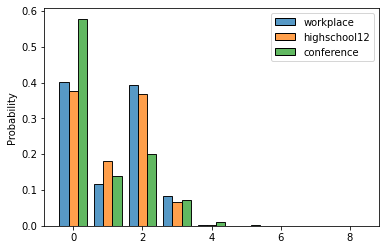

In [75]:
sns.histplot(
    data={s: np.concatenate(r) for s, r in zip(settings, reaches)},
    multiple='dodge',
    stat='probability',
    shrink=0.8,
    discrete=True,
    common_norm=False,
    common_bins=True);

In [46]:
df.groupby('Setting')[['RuntimeInSeconds']].describe()

RuntimeInSeconds                                          \
                        count      mean       std      min        25%   
Setting                                                                 
conference               10.0  20.99346  4.614641  13.6300  18.448325   
highschool12             10.0   3.58400  0.896087   2.4240   2.967000   
workplace                10.0   6.78753  1.799601   4.3287   5.629075   

                                            
                   50%        75%      max  
Setting                                     
conference    20.34610  24.944950  27.6474  
highschool12   3.39165   4.319525   5.0706  
workplace      6.64545   8.002600   9.5305

In [47]:
df.groupby('Setting')[['Messages']].describe()

Messages                                                         \
                count    mean          std     min      25%     50%      75%   
Setting                                                                        
conference       10.0  6494.7  1467.200437  4137.0  5651.25  6415.5  7516.00   
highschool12     10.0  2309.5   593.879009  1529.0  1889.25  2199.0  2569.50   
workplace        10.0  2690.8   748.401229  1581.0  2296.50  2625.0  3040.25   

                      
                 max  
Setting               
conference    8868.0  
highschool12  3245.0  
workplace     3994.0

In [48]:
df.groupby('Setting')[['ReachabilityRatio']].describe()

ReachabilityRatio                                                \
                         count     mean       std     min       25%      50%   
Setting                                                                        
conference                10.0  0.39019  0.005370  0.3831  0.386200  0.38905   
highschool12              10.0  0.29294  0.007059  0.2791  0.289975  0.29290   
workplace                 10.0  0.39706  0.008054  0.3833  0.393700  0.39815   

                                
                   75%     max  
Setting                         
conference    0.395200  0.3980  
highschool12  0.296975  0.3054  
workplace     0.402525  0.4072

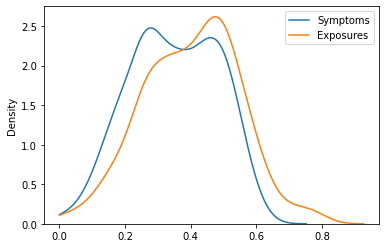

In [49]:
symptoms = np.array(get_symptoms(load_real_world_log('conference')))
exposures = np.array(get_exposures(load_real_world_log('conference')))

sns.kdeplot(symptoms.mean(axis=0), clip=(0, 1));
sns.kdeplot(exposures.mean(axis=0), clip=(0, 1));
plt.legend(['Symptoms', 'Exposures']);

In [71]:
ratios = []
for reach, setting in zip(reaches, settings):
    symptoms = np.array(get_symptoms(load_real_world_log(setting)))
    expected, actual = compare_reaches(symptoms, reach, alpha=0.8, gamma=0.6)
    ratios.append(ratio := expected[0] / actual[0])
    print(f'{setting}:\t {round(ratio, 3)}x actual reachability')
mean, err = round(np.mean(ratios), 3), round(1.96 * sp.stats.sem(ratios), 3)
print(f'overall:\t ({mean} +/- {err})x actual reachability')

workplace:	 2.143x actual reachability
highschool12:	 2.213x actual reachability
conference:	 3.189x actual reachability
overall:	 (2.515 +/- 0.662)x actual reachability
